In [1]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

## データインポート(MNIST)

ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用します。各種ライブラリやサイトからダウンロードできますが、ここでは深層学習フレームワークのKerasを用います。以下のコードを実行すればデータセットをダウンロードし、展開まで行えます。


### 《データセットをダウンロードするコード》

In [290]:
import tensorflow as tf

In [291]:
from keras.datasets import mnist

In [292]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### 《MNISTとは？》


画像分類のための定番データセットで、手書き数字認識を行います。このデータセットには訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベルが含まれています。


### 《画像データとは？》


デジタル画像は点の集合で、これをピクセルと呼びます。一般的に白黒画像であればピクセルには0〜255の値が含まれます。一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われます。0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できます。


データセットの確認
どういったデータなのかを見てみます。


### 《サンプルコード》

In [293]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


各データは28×28ピクセルの白黒画像です。

## 平滑化

(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。全てのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現します。


### 《サンプルコード》

In [294]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [295]:
X_train.shape

(60000, 784)

### 《補足》

ここまで機械学習を学んでくる中で、特徴量の数を「次元」と呼んできました。その視点ではMNISTは784次元のデータです。一方で、NumPyのshapeが(784,)の状態を1次元配列とも呼びます。画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列です。この視点では2次元のデータです。さらに、もしもカラー画像であれば(28, 28, 3)ということになり、3次元配列です。先ほどの視点では3次元のデータになります。しかし、白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータです。画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意してください。

## 画像データの可視化
画像データを可視化します。plt.imshowに渡します。


### 《サンプルコード》

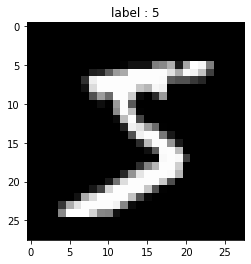

In [296]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()


[numpy.reshape — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)


[matplotlib.pyplot.imshow — Matplotlib 3.1.1 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html)


### 《発展的話題》


画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。



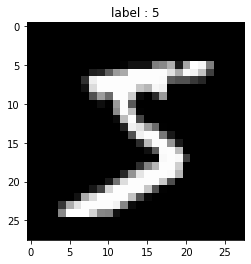

[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35]


In [297]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image[0]) # 値を確認


これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。



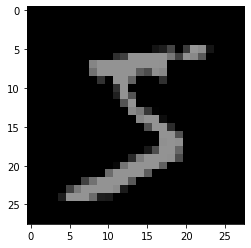

In [298]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておきましょう。

## 前処理
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。


### 《サンプルコード》

In [299]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
print(X_train[0].dtype) 

1.0
0.0
float64


また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

### 《サンプルコード》

In [300]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


[sklearn.preprocessing.OneHotEncoder — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)


さらに、訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。


### 《サンプルコード》



In [301]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [302]:
y_train.shape

(48000, 10)

---

# 3.ニューラルネットワークスクラッチ

---

ニューラルネットワークのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


今回は多クラス分類を行う3層のニューラルネットワークを作成します。層の数などは固定した上でニューラルネットワークの基本を学びます。次のSprintで層を自由に変えられる設計にしていきます。


以下に雛形を用意してあります。このScratchSimpleNeuralNetrowkClassifierクラスにコードを書き加えていってください。


### 《雛形》

In [15]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose = True):
        self.verbose = verbose
        pass
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pass
        return

## ミニバッチ処理
これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。


今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練データを一度全て見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。


これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。


### 《コード》



In [16]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

このクラスをインスタンス化し、for文を使うことでミニバッチが取り出せます。

In [17]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0


\__getitem__や\__next__は\__init__と同じ特殊メソッドの一種です。

###  ミニバッチクラスに関しての自分の概観
* ミニバッチはデータを分割してるので、Xとyを今回で言えば20個ずつ計2400に分けているだけ。
* 学習率を変えていけば、エポックが終わる前に大体損失関数が落ち着いていく。つまり早く終わる。全部舐めるか終了条件で一回(epoch:1)、エポックを複数回、回すたびにシャッフルすることで精度をあげる。
* \__init__でシャッフルしたインデックスを与えてself._Xを作ってる(yも)
* \__getitem__はインスタンスに[ ]をつけたときの挙動を決めている。getitem前にはまだデータの分割はしてないので、[ ]に入れた数字をバッチサイズに掛けてindexを取り出している。例：[5]なら [(100) : (100) + 20]のインデックスを取り出すよ、ということ
* \__iter__はオブジェクトをイテレータ化することを要求されたときに呼ばれるメソッド。処理としては今回はself._counterをゼロで初期化しているだけ。forで呼ばれる時に\__iter__は動く
* \__next__はイテレートされるべきプロパティを変更し、戻り値として現在地を返す。終了条件に合致していたら終了の例外を返す。今回は、forループの中でindexを一つずつ(self._counterが増加した分)ずらしたself._Xとyをreturnする。
* 今回の終了条件は if self._counter >= self._stop: なので、self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)の2400回を超えたらStopIterationする。

## 学習
ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。

# 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。


### 《サンプルコード》

In [18]:
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)
print(W1)

[[ 0.00792546 -0.00145092 -0.01287133 ... -0.00245453 -0.03460641
   0.00758269]
 [-0.00137276  0.00278289  0.00932826 ... -0.01495581  0.00968798
   0.0101332 ]
 [-0.00746748  0.00905245  0.0006038  ...  0.01249155 -0.00529285
   0.00730488]
 ...
 [-0.00811823  0.01002275 -0.00182602 ...  0.00378093  0.02126478
  -0.01424466]
 [-0.00437306 -0.00940798 -0.00387237 ... -0.01876301  0.00512501
  -0.00062903]
 [ 0.00909606  0.00415442 -0.00521814 ...  0.01918723 -0.00667915
   0.00316757]]


[numpy.random.randn — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html)

### 【解答】関数

In [19]:
#W,b行列の初期化
def init_Wb(sigma=0.01, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10):
    W1 = sigma * np.random.randn(n_features, n_nodes1)
    W2 = sigma * np.random.randn( n_nodes1, n_nodes2)
    W3 = sigma * np.random.randn( n_nodes2, n_output)
    b1 = sigma * np.random.randn(n_nodes1)
    b2 = sigma * np.random.randn(n_nodes2)
    b3 = sigma * np.random.randn(n_output)
    return W1, W2, W3, b1, b2, b3

In [20]:
W1, W2, W3, b1, b2, b3 = init_Wb()
#W1, W2, W3, b1, b2, b3

In [21]:
W1.shape

(784, 400)

# 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。


* batch_size = 20 # バッチサイズ
* n_features = 784 # 特徴量の数
* n_nodes1 = 400 # 1層目のノード数
* n_nodes2 = 200 # 2層目のノード数
* n_output = 10 # 出力のクラス数（3層目のノード数）

「1層目」

$$
A_1=X⋅W_1+B_1
$$

$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)


$B_1$ : 1層目のバイアス (n_nodes1,)


$A_1$ : 出力 (batch_size, n_nodes1)


「1層目の活性化関数」

$$
Z_1=f(A_1)
$$

$f()$ : 活性化関数


$Z_1$ 出力 (batch_size, n_nodes1)


「2層目」

$$
A_2=Z_1⋅W_2+B_2
$$

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


$B_2$ : 2層目のバイアス (n_nodes2,)


$A_2$ : 出力 (batch_size, n_nodes2)


「2層目の活性化関数」

$$
Z_2=f(A_2)
$$

$f()$ : 活性化関数


$Z_2$ 出力 (batch_size, n_nodes2)


「3層目（出力層）」

$$
A_3=Z_2⋅W_3+B_3
$$

$W_3$ : 3層目の重み (n_nodes2, n_output)


$B_3$ : 3層目のバイアス (n_output,)


$A_3$ : 出力 (batch_size, n_output)


「3層目の活性化関数」

$$
Z_3=softmax(A_3)
$$

$softmax()$ : ソフトマックス関数


$Z_3$ 出力 (batch_size, n_output)


$Z_3$ は各ラベル（0〜9）に対する確率の配列である。

## 活性化関数（フォワードプロバゲーション）
活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。


「シグモイド関数」

$$
f(Z)=sigmoid(A)=\frac{1}{1+exp(-A)}
$$

指数関数 $exp(-A)$ の計算はnp.expを使用してください。


[numpy.exp — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.exp.html)


「ハイパボリックタンジェント関数」


次の数式で表されますが、np.tanhひとつで実現できます。


$$
f(Z)=tanh(A)=\frac{exp(A) - exp(-A)}{exp(A)+exp(-A)}
$$

[numpy.tanh — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.tanh.html)


＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。


## ソフトマックス関数
ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。


次の数式です。


$$
Z_{3\_k}=\frac{exp(A_{3\_k})}{\Sigma^{n_c}_{i=1}exp(A_{3\_i})}
$$

$Z_{3_k}$ : $k$ 番目のクラスの確率ベクトル (batch_size,)


$A_{3_k}$ : $k$ 番目のクラスにあたる前の層からのベクトル (batch_size,)


$n_c$ : クラスの数、n_output。今回のMNISTでは10。


分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に $k$ 番目のクラスを持ってくることで、 $k$ 番目のクラスである確率が求まります。


これを10クラス分計算し、合わせたものが $Z_3$ です。



In [22]:
#Sigmoid:1/(1+exp(-x))
def sigmoid_forward(A):
    return 1 / (1 + np.exp(-np.clip(A, -250, 250)))

In [23]:
#Tanh:(exp(x)-exp(-x))/(exp(x)+xp(-x))
def tanh_forward(A):
    return np.tanh(A)
    #return ((exp(A)-exp(-A)) / (exp(A)+exp(-A)))

In [24]:
#Softmax:
def before_softmax_forward(A):
    #A = A[None,:]
    #A = A - np.max(A)
    Z = np.exp(A) / np.sum(np.exp(A))
    return Z

In [25]:
#Softmax:
def softmax_forward(A):
    #print(A[i])
    maxA = np.max(A)
    #print(maxA)
    frac1 = np.exp(A-maxA)
    frac2 = np.sum(frac1, axis=0,  keepdims=True)
    #print(frac1)
    #print(frac2)
    
    Z = frac1 / frac2
    return Z

In [26]:
X = np.array([[1,1],[2,2],[3,3]])#バッチサイズ３,入力サイズ２
b = np.array([1,2,3])
w = np.array([[1,2],[3,4],[5,6]])#出力サイズ３,入力サイズ２

In [27]:
A = np.dot(X, w.T) + b
print(A)

t1 = sigmoid_forward(A)
t2 = tanh_forward(A)
t3 = softmax_forward(A)
print(t1)
print(t2)
print(t3)


[[ 4  9 14]
 [ 7 16 25]
 [10 23 36]]
[[0.98201379 0.99987661 0.99999917]
 [0.99908895 0.99999989 1.        ]
 [0.9999546  1.         1.        ]]
[[0.9993293  0.99999997 1.        ]
 [0.99999834 1.         1.        ]
 [1.         1.         1.        ]]
[[2.35563308e-03 8.30770464e-07 2.78942150e-10]
 [4.73141552e-02 9.11050438e-04 1.67014218e-05]
 [9.50330212e-01 9.99088119e-01 9.99983298e-01]]


In [28]:
def forward_propagation(X, W1=W1,W2=W2,W3=W3,b1=b1,b2=b2,b3=b3, activation="sigmoid"):
    """
    activation = "sigmoid", "tanh"

    """
    
    #X = np.concatenate([np.ones((X.shape[0], 1)), X], 1)
    A1 = np.dot(X, W1) + b1
    #print("A1shape:{}".format(A1.shape))
    #print(A1[0])
    if activation=="sigmoid":
        Z1 = sigmoid_forward(A1)
    elif activation=="tanh":
        Z1 = tanh_forward(A1)
    
    #Z1 = np.concatenate([np.ones((Z1.shape[0], 1)), Z1], 1)
    A2 = np.dot(Z1, W2)+ b2
    #print(A2[0])    
    if activation=="sigmoid":
        Z2 = sigmoid_forward(A2)
    elif activation=="tanh":
        Z2 = tanh_forward(A2)    

    #Z2 = np.concatenate([np.ones((Z2.shape[0], 1)), Z2], 1)
    A3 = np.dot(Z2, W3)+ b3
    #print("A3shape:{}".format(A3.shape))
    #print(A3[0])
    #print(A3[1])
    
    Z3 = softmax_forward(A3)
    #for i in range(A3.shape[1]):
        #Z3 = before_softmax_forward(A3[i])
        #print(Z3)
    
    return A1, A2, A3, Z1, Z2, Z3

In [44]:
XX = X_train[0:20]
#print(XX[0])
A1, A2, A3, Z1, Z2, Z3 = forward_propagation(XX)
print(Z2)

[[0.48774539 0.51666212 0.48739149 ... 0.4873837  0.50622105 0.50734978]
 [0.48623013 0.51681003 0.48772308 ... 0.48535254 0.50711493 0.50736726]
 [0.48600662 0.51754508 0.48748463 ... 0.48620071 0.50592052 0.50668922]
 ...
 [0.48505335 0.51536456 0.49125366 ... 0.48734569 0.50369992 0.50672948]
 [0.48550525 0.51678207 0.4883651  ... 0.48562971 0.5062078  0.50681612]
 [0.48722031 0.51525015 0.48991703 ... 0.48680323 0.50563468 0.50722366]]


In [42]:
for i in range(5):
    XX = X_train[i]
    A1, A2, A3, Z1, Z2, Z3 = forward_propagation(XX)
    print(Z3)

[0.09558107 0.09289387 0.10736005 0.10365054 0.11155104 0.08694645
 0.09997299 0.09482165 0.10611821 0.10110413]
[0.09559843 0.09288141 0.10733382 0.10364304 0.11157645 0.08695905
 0.09994579 0.0948263  0.10611677 0.10111893]
[0.09558433 0.09286959 0.10736747 0.10364727 0.11157356 0.08695478
 0.09994282 0.09483177 0.10612742 0.10110099]
[0.09560138 0.09285421 0.10734682 0.10366612 0.11156324 0.08693333
 0.09994024 0.09483995 0.10612749 0.10112722]
[0.09556893 0.09289829 0.10735737 0.10365724 0.11156337 0.08694637
 0.09995713 0.09481171 0.10612917 0.10111041]


# 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。


$$
L=-\frac{1}{n_b}\Sigma^{n_b}_j \Sigma^{n_c}_k y_{jk}log(z_{3\_jk})
$$

$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）


$n_{b}$ : バッチサイズ、batch_size


$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）


サンプル1つあたりの誤差が求まります。

In [45]:
y_train.shape

(48000, 10)

In [46]:
def test_Cross_entropy_Loss(y_train, Z3):
    batch_size = Z3.shape[0]
    loss = -np.sum(y_train * np.log(Z3)) / batch_size
    return loss

In [47]:
test_Cross_entropy_Loss(y_train[100:120], Z3)

2.995740617402417

In [48]:
def for_cross_entropy_error(y_train, Z3) :
    loss = 0
    for j in range(Z3.shape[0]):
        for k in range(Z3.shape[1]):
            loss += y_train[j][k] * np.log(Z3[j][k])
            
    return -loss / Z3.shape[0]

In [49]:
for_cross_entropy_error(y_train[100:120], Z3)

2.995740617402417

# 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。


数式を以下に示します。


まず、i層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。

$$
W^′_i=W_i-\alpha\frac{∂L}{∂W_i}
$$
$$
B^′_i=B_i-\alpha\frac{∂L}{∂Bi}
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。


この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。


勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。


「3層目」

$$
\frac{\partial L}{\partial A_3}=Z_3-Y
$$
$$
\frac{\partial L}{\partial B_3}=\Sigma^{n_b}_j\frac{\partial L}{\partial A_{3\_j}}
$$
$$
\frac{\partial L}{\partial W_3}=Z^T_2⋅\frac{\partial L}{\partial A_3}
$$
$$
\frac{\partial L}{\partial Z_2}=\frac{\partial L}{\partial A_3}⋅W^T_3
$$

$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)


$\frac{\partial L}{\partial A_{3_j}}$ : j番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)


$Y$ : 正解ラベル (batch_size, n_output)


$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)


$W_3$ : 3層目の重み (n_nodes2, n_output)


「2層目」

$$
\frac{\partial L}{\partial A_2}=\frac{\partial L}{\partial Z_2}\odot\{1-tanh^2(A_2)\}
$$
$$
\frac{\partial L}{\partial B_2}=\Sigma^{n_b}_j\frac{\partial L}{\partial A_{2\_j}}
$$
$$
\frac{\partial L}{\partial W_2}=Z^T_1⋅\frac{\partial L}{\partial A_2}
$$
$$
\frac{\partial L}{\partial Z_1}=\frac{\partial L}{\partial A_2}⋅W^T_2
$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$\frac{\partial L}{\partial A_{2_j}}$ : j番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$A_2$ : 2層目の出力 (batch_size, n_nodes2)


$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)


$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


「1層目」


$$
\frac{\partial L}{\partial A_1}=\frac{\partial L}{\partial Z_1}\odot\{1-tanh^2(A_1)\}
$$
$$
\frac{\partial L}{\partial B_1}=\Sigma^{n_b}_j\frac{\partial L}{\partial A_{1\_j}}
$$
$$
\frac{\partial L}{\partial W_1}=X^T⋅\frac{\partial L}{\partial A_1}
$$


$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$\frac{\partial L}{\partial A_{1_j}}$ : j番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)


$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$A_1$ : 1層目の出力 (batch_size, n_nodes1)


$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)


### 《補足》


活性化関数にシグモイド関数を使用した場合は、次のようになります。

$$
\frac{\partial L}{\partial A_2}=\frac{\partial L}{\partial Z_2}= \odot\{1- sigmoid(A_2)\}sigmoid(A_2)
$$
$$
\frac{\partial L}{\partial A_1}=\frac{\partial L}{\partial Z_1}= \odot\{1- sigmoid(A_1)\}sigmoid(A_1)
$$


### 【解答】一つずつ実装していく

In [173]:
# 出力層
def error_output(y_train, Z3):
    """error function at the output"""
    eo = y_train - Z3
    return eo


def gradient_weight_output(Z2, eo):
    """gradients for the weight parameter at the output layer"""
    return   Z2.T @ eo


def gradient_bias_output(eo):
    """gradients for the bias parameter at the output layer"""
    return np.sum(eo, axis=0, keepdims=True)


In [177]:
eo = error_output(y_train[100:120], Z3)
eo

array([[ 0.95000491, -0.05001154, -0.0500038 , -0.04999646, -0.04999226,
        -0.04999771, -0.05001215, -0.04999765, -0.04999463, -0.04999334],
       [-0.05000219, -0.05000286, -0.04998961, -0.04999086, -0.05000167,
         0.94999702, -0.04999657, -0.04999813, -0.04999197, -0.04999869],
       [ 0.9500031 , -0.04999857, -0.05000736, -0.04999499, -0.05000245,
        -0.0500026 , -0.04999717, -0.05000309, -0.04999907, -0.04999189],
       [-0.05000456, -0.04998904, -0.04999648, -0.05000282, -0.04999657,
        -0.04998901, -0.04999462, -0.05000615, -0.04999785,  0.9499964 ],
       [-0.0499917 , -0.05001689, -0.05000551, -0.05000265, -0.05000074,
        -0.05000062, -0.05000718, -0.04999537,  0.94999725, -0.04999941],
       [-0.04999603,  0.95000339, -0.04999353, -0.05000569, -0.05000183,
        -0.05001258, -0.05000351, -0.04999748, -0.05000751, -0.05001009],
       [-0.0500051 , -0.04999751, -0.05000454, -0.05000048, -0.05000523,
        -0.05000627, -0.04998976, -0.05000487

In [175]:
bais_output = gradient_bias_output(eo)
bais_output.shape

(1, 10)

In [176]:
weight_output = gradient_weight_output(Z2, eo)
weight_output

array([[0.97526997, 0.48836587, 0.97223021, ..., 0.48622376, 0.48884411,
        0.97179804],
       [1.03347046, 0.51475022, 1.03242349, ..., 0.51688692, 0.51863408,
        1.03355725],
       [0.97589755, 0.48839719, 0.98009516, ..., 0.48819549, 0.48986395,
        0.97925914],
       ...,
       [0.97459702, 0.48523402, 0.97310175, ..., 0.48620224, 0.4864084 ,
        0.97478992],
       [1.01226887, 0.50796871, 1.01300043, ..., 0.50895557, 0.50850927,
        1.00938856],
       [1.01422597, 0.5070899 , 1.01257994, ..., 0.50620436, 0.50666072,
        1.01374623]])

In [134]:
# 二層目
def error_second(eo, W3, A2):
    """error at the second layer"""
    es = np.dot(eo, W3.T) * (sigmoid_forward(A2) * (1 - sigmoid_forward(A2)))
    return es


def gradient_weight_second(Z1, es):
    """gradients for the weight parameter at the output layer"""
    return Z1.T @ es / 20


def gradient_bias_second(es):
    """gradients for the bias parameter at the output layer"""
    return np.sum(es, axis=0, keepdims=True)

In [135]:
es = error_second(eo, W3, A2)
es.shape

(20, 200)

In [136]:
bias_second = gradient_bias_second(es)
bias_second.shape

(1, 200)

In [138]:
weight_second = gradient_weight_second(Z1, es)
weight_second

array([[-6.14431472e-04, -5.54665432e-04,  5.90867014e-05, ...,
        -1.70523028e-04,  1.60615339e-04, -3.27757451e-05],
       [-6.33005442e-04, -5.84863852e-04,  5.66073817e-05, ...,
        -1.42991338e-04,  1.97976253e-04, -5.44420119e-05],
       [-6.05361838e-04, -5.64485802e-04,  6.33050926e-05, ...,
        -1.54716942e-04,  1.71633705e-04, -4.18735689e-05],
       ...,
       [-6.36943585e-04, -5.65171499e-04,  5.38748299e-05, ...,
        -1.59167104e-04,  1.71510993e-04, -4.78519724e-05],
       [-6.38154283e-04, -5.82544643e-04,  4.01878908e-05, ...,
        -1.53616055e-04,  1.77385135e-04, -4.54103321e-05],
       [-5.75529129e-04, -5.36099415e-04,  5.22165165e-05, ...,
        -1.49034251e-04,  1.66118206e-04, -3.88255608e-05]])

In [139]:
# 一層目
def error_first(es, W2, A1):
    """error at the first layer"""
    ef = np.dot(es, W2.T) * (sigmoid_forward(A1) * (1 - sigmoid_forward(A1)))
    return ef


def gradient_weight_first(X_train, ef):
    """gradients for the weight parameter at the first layer"""
    return X_train.T @ ef / 20


def gradient_bias_first(ef):
    """gradients for the bias parameter at the first layer"""
    return np.sum(ef, axis=0, keepdims=True)

In [140]:
ef = error_first(es, W2, A1)
ef.shape

(20, 400)

In [141]:
bias_first = gradient_bias_first(ef)
bias_first.shape

(1, 400)

In [142]:
weight_first = gradient_weight_first(X_train[100:120], ef)
weight_first.shape

(784, 400)

# 【問題5】推定
推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。


[numpy.argmax — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)

In [62]:
def predict(X):
    _,_,_,_,_,yy = forward_propagation(X)
    return np.argmax(yy, axis=1)


In [63]:
predict(X_train[120:140])

array([7, 6, 5, 1, 4, 5, 7, 7, 5, 5, 8, 5, 6, 7, 5, 1, 4, 4, 3, 7])

# 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [342]:
import copy
import time

class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        準伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_
    
    
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
        
        return self.dA_
        
class Tanh:
    """
    ハイパボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_ ** 2)
        
        return self.dA_ 

class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
    
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class SSScratchSimpleNeuralNetworkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    
    Parameters
    ----------
    epoch : int
      エポック数
    lr : float
      学習率
    sigma : float
      初期パラメータ用
    n_nodes1 : int
      1層目のノード数
    n_nodes2 : int
      2層目のノード数
    n_output : int
      出力層のノード数
    batch_size : int
      ミニバッチのサンプル数
      
    Attributes
    ----------
    w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      重みパラメータ
    b : 次の形のndarray, shape (n_nodes_self, )
      バイアスパラメータ
    loss_train : list
      訓練データに対するLoss
    loss_val : list
      検証データに対するLoss
    verbose : bool
      学習経過の出力
    """
    
    def __init__(self, epoch=10, sigma=0.1, lr=0.1, n_nodes1=400, n_nodes2=200, n_output=10, batch_size=20, verbose=False, **kwargs):
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.batch_size = batch_size
        self.w = None
        self.b = None
        self.loss_train = []
        self.loss_val = []
        self.verbose = verbose    

    def _params_init(self, n_features, n_output):
        """
        3層ニューラルネット用のパラメータ初期化関数

        Returns
        -------
        w_params : list
          各層の重みを格納したリスト
        b_params : list
          各層のバイアスを格納したリスト
        """
        W1 = self.sigma * np.random.randn(n_features, self.n_nodes1)
        W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        W3 = self.sigma * np.random.randn(self.n_nodes2, n_output)

        B1 = np.random.randn(self.n_nodes1)
        B2 = np.random.randn(self.n_nodes2)
        B3 = np.random.randn(n_output)

        w_params = np.array([W1, W2, W3], dtype='object')
        b_params = np.array([B1, B2, B3], dtype='object')

        return w_params, b_params
    

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes)
            検証データの正解値
        """
        w, b = self._params_init(len(X[0]), self.n_output)

        # レイヤーインスタンスを作成
        linear_1 = copy.deepcopy(Linear())
        activ_1 = copy.deepcopy(Sigmoid())
        linear_2 = copy.deepcopy(Linear())
        activ_2 = copy.deepcopy(Sigmoid())
        linear_3 = copy.deepcopy(Linear())
        softmax = copy.deepcopy(Softmax())

        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:
                
                # 順伝播
                A1 = linear_1.forward(X_mini, w[0], b[0])
                Z1 = activ_1.forward(A1)

                A2 = linear_2.forward(Z1, w[1], b[1])
                Z2 = activ_2.forward(A2)

                A3 = linear_3.forward(Z2, w[2], b[2])
                Z3 = softmax.forward(A3)

                # 逆伝播
                dA3 = softmax.backward(y_mini)
                dZ2, dw3, db3 = linear_3.backward(Z2, w[2], dA3)

                dA2 = activ_2.backward(dZ2)
                dZ1, dw2, db2 = linear_2.backward(Z1, w[1], dA2)

                dA1 = activ_1.backward(dZ1)
                _, dw1, db1 = linear_1.backward(X_mini, w[0], dA1)

                # 確率的勾配降下法
                w -= self.lr * np.array([dw1, dw2, dw3], dtype='object') 
                b -= self.lr * np.array([db1, db2, db3], dtype='object') 
                
                # 損失関数
                loss_batch_t.append(self.cross_entropy(Z3, y_mini, len(X_mini)))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    A1 = linear_1.forward(X_mini, w[0], b[0])
                    Z1 = activ_1.forward(A1)

                    A2 = linear_2.forward(Z1, w[1], b[1])
                    Z2 = activ_2.forward(A2)

                    A3 = linear_3.forward(Z2, w[2], b[2])
                    Z3 = softmax.forward(A3)
                
                    loss_batch_v.append(self.cross_entropy(Z3, y_mini, len(X_mini)))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)
            
            end = time.time()
            
            times.append(end-start)


            if self.verbose and (i+1) % 10 == 0:
                print("Epoch {}; Loss {:.4f}".format(i+1, loss_train),
                      "  --Avg Epoch Time {:.4f}sec".format(np.mean(times)))
                
        # 全epoch終了後のパラメータを保存    
        self.w = w
        self.b = b

        
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, )
            推定結果
        """
        #print(X.shape)
        #print(self.W[0])
        #print(self.b[0])
        A1 = Linear().forward(X, self.w[0], self.b[0])
        Z1 = Sigmoid().forward(A1)

        A2 = Linear().forward(Z1, self.w[1], self.b[1])
        Z2 = Sigmoid().forward(A2)

        A3 = Linear().forward(Z2, self.w[2], self.b[2])
        Z3 = Softmax().forward(A3)
        
        return np.argmax(Z3, axis=1)
        
    
    def cross_entropy(self, X, y, batch_size):
        """
        クロスエントロピー誤差を計算

        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
          入力データ
        y : 次の形のndarray, shape (batch_size, n_classes)
          入力データの正解ラベル

        Returns
        -------
          float
          クロスエントロピー誤差
        """
        return (-1/batch_size) * np.sum((y*np.log(X)))

In [343]:
params = {'epoch': 100, 
          'lr': 0.01,
          'sigma':  0.1,
          'batch_size': 200}
print(params)

scratch_nn = SSScratchSimpleNeuralNetworkClassifier(verbose=True, **params)
scratch_nn.fit(X_train, y_train, X_val, y_val)

pred = scratch_nn.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

{'epoch': 100, 'lr': 0.01, 'sigma': 0.1, 'batch_size': 200}
Epoch 10; Loss 0.0607   --Avg Epoch Time 2.8663sec
Epoch 20; Loss 0.0161   --Avg Epoch Time 2.8388sec
Epoch 30; Loss 0.0047   --Avg Epoch Time 2.9130sec
Epoch 40; Loss 0.0022   --Avg Epoch Time 2.8304sec
Epoch 50; Loss 0.0013   --Avg Epoch Time 2.8418sec
Epoch 60; Loss 0.0010   --Avg Epoch Time 2.7593sec
Epoch 70; Loss 0.0007   --Avg Epoch Time 2.7106sec
Epoch 80; Loss 0.0006   --Avg Epoch Time 2.9743sec
Epoch 90; Loss 0.0005   --Avg Epoch Time 2.7251sec
Epoch 100; Loss 0.0004   --Avg Epoch Time 2.7491sec

 Accuracy: 0.9811


In [373]:
pred = temp.predict(X_test)
print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))


 Accuracy: 0.9784


# 【問題7】学習曲線のプロット
学習曲線をプロットしてください。


ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。



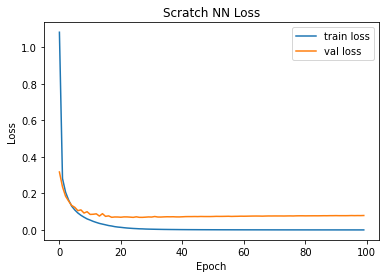

In [374]:
%matplotlib inline


def plot_loss(model, title='Scratch NN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    
plot_loss(scratch_nn)

# 【問題8】（アドバンス課題）誤分類の確認
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。


### 《コード》

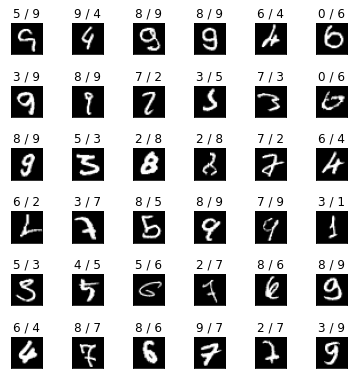

In [376]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = pred == y_test
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(pred[false_list[i]],y_test[false_list[i]]))
    ax.imshow(X_test.reshape(-1,28,28)[false_list[i]], cmap='gray')

人間の目でも判別しにくいものが多い。